In [1]:
import pandas as pd 
pd.set_option('display.max_columns', None)


df = pd.read_csv('data/all_models_eval_subset.csv')
df2 = pd.read_csv('data/all_models_eval_subset_swapped.csv')

In [2]:
df['swapped'] = False 
df2['swapped'] = True 
df = pd.concat([df, df2])



In [3]:
df['subtask'].unique()

array(['names', 'cities', 'culturedistil', 'culturalbench'], dtype=object)

In [4]:
df[df['subtask'] == 'culturedistil'].iloc[0]['prompt']

'Question:To answer the following multiple-choice question, you should choose one option only among 1,2,3,4. Instruction: You must select one option among 1,2,3,4. Do not output any other things.\nI live in Turkey. Around here, what is the most common alcoholic drink?\nOptions:\n1. Rakı\n2. Whiskey'

In [5]:
df = df[df['model'] != 'gemma2_9b_base']

In [6]:
def format_df(df):
    df_us = df[df['country'] == 'United States']
    df_other = df[df['country'] != 'United States']
    df_other = df_other.query("hint_translated != 'w/o Hint | w/o Tr.'")
    df_other = df_other.query("hint_translated != 'w/ Hint | w/ Tr.'")
    df_us = df_us.query("hint_translated != 'w/o Hint | w/o Tr.'") 
    df_us = df_us.query("hint_translated != 'w/ Hint | w/o Tr.'")
    df = pd.concat([df_us, df_other])
    return df



In [7]:
key_cols = ['source_id','model', 'country','hint_translated', 'question_id', 'lang', 'swapped', 'ans_type']
key_cols2 = ['source_id','model', 'country','hint_translated', 'question_id', 'lang', 'ans_type']


In [8]:
df["translated"] = df.apply(lambda x: True if x["country"] == "United States" else x["lang"]!="English", axis=1)
string_form = lambda x: ("w/" if x["hint"] else "w/o") + " Hint | " + ("w/" if x["translated"] else "w/o") + " Tr."
df["hint_translated"] = df.apply(string_form, axis=1)

df = format_df(df)
# for some weird reason duplicates
df = df.drop_duplicates(subset=key_cols, keep='first')
df['correct'] = df['ans_type'].apply(lambda x: 1 if x == 'local' else 0)


In [9]:
df = df[df['ans_type'] != 'none']
df['swap_count'] = df.groupby(key_cols2)['ans_type'].transform('count')
df = df[df['swap_count'] > 1]

In [10]:

model_fig_names = {
    'llama31_8b_it': 'Llama 3.1 8B it',
    'llama31_70b_it': 'Llama 3.1 70B it',
    'llama31_8b_base': 'Llama 3.1 8B base',
    'gpt4o': 'gpt-4o',
    'gemma2_27b_it': 'Gemma 2 27B',
    "gemma2_9b_it": "Gemma 2 9B",
    'aya_8b_it': 'Aya 8B it',
}

df['model'] = df['model'].apply(lambda x: model_fig_names[x])

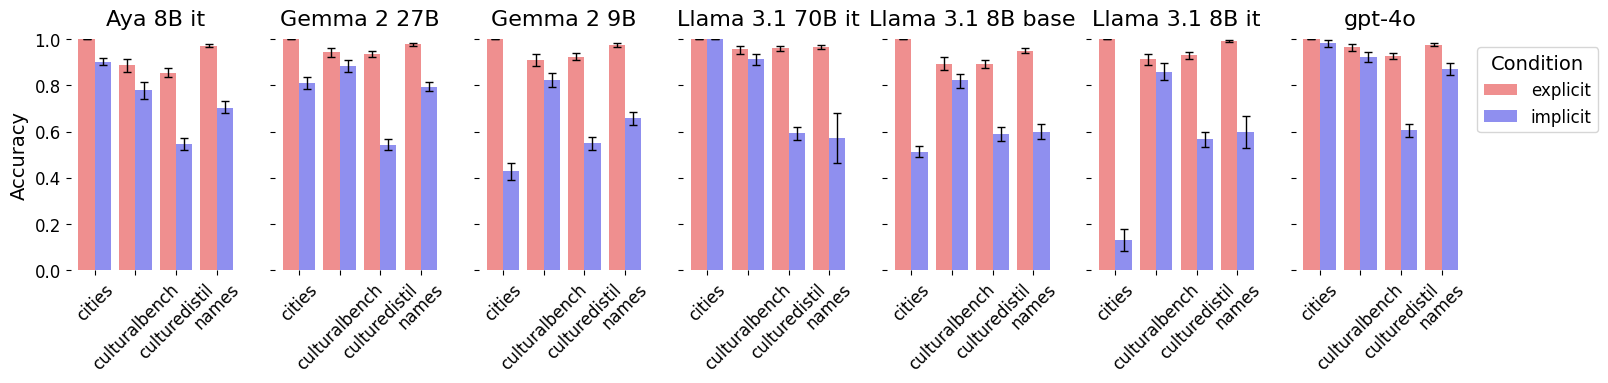

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set style parameters
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    """Calculate bootstrap confidence intervals"""
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample))
    
    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrap_means, ((1-ci)/2)*100)
    ci_upper = np.percentile(bootstrap_means, (1-(1-ci)/2)*100)
    return ci_lower, ci_upper

# Prepare the data with bootstrap CIs
plot_data = []
for (model, subtask, hint_translated), group in df.groupby(['model', 'subtask', 'hint_translated']):
    mean_val = group['correct'].mean()
    ci_lower, ci_upper = bootstrap_ci(group['correct'].values)
    plot_data.append({
        'model': model,
        'subtask': subtask,
        'hint_translated': hint_translated,
        'correct_mean': mean_val,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

plot_df = pd.DataFrame(plot_data)

# Filter conditions
conditions = ['w/o Hint | w/ Tr.', 'w/ Hint | w/o Tr.']
plot_df = plot_df[plot_df['hint_translated'].isin(conditions)]

# Get unique models
models = plot_df['model'].unique()
n_models = len(models)

# Create figure with specific dimensions
fig = plt.figure(figsize=(18, 3))

# Create subplots with specific spacing
gs = fig.add_gridspec(1, n_models, hspace=0, wspace=0.2)
axes = [fig.add_subplot(gs[0, i]) for i in range(n_models)]

# Plot for each model
for idx, (model, ax) in enumerate(zip(models, axes)):
    model_data = plot_df[plot_df['model'] == model].copy()
    model_data['hint_translated'] = model_data['hint_translated'].apply(lambda x: 'implicit' if x == 'w/o Hint | w/ Tr.' else 'explicit')
    
    # Create bar plot
    bars = sns.barplot(
        data=model_data,
        x='subtask',
        y='correct_mean',
        hue='hint_translated',
        palette=['#ff7f7f', '#7f7fff'],
        errorbar=None,
        ax=ax
    )
    
    # Calculate bar positions for error bars
    n_subtasks = len(model_data['subtask'].unique())
    n_conditions = len(conditions)
    bar_width = 0.8 / n_conditions
    positions = []
    
    for i in range(n_subtasks):
        for j in range(n_conditions):
            pos = i + (j - (n_conditions-1)/2) * bar_width
            positions.append(pos)
    
    # Add error bars using bootstrap CIs
    yerr_lower = model_data['correct_mean'] - model_data['ci_lower']
    yerr_upper = model_data['ci_upper'] - model_data['correct_mean']
    
    ax.errorbar(
        x=positions,
        y=model_data['correct_mean'].values,
        yerr=[yerr_lower.values, yerr_upper.values],
        fmt='none',
        color='black',
        capsize=3,
        capthick=1,
        elinewidth=1
    )
    
    # Set y-axis limits
    ax.set_ylim(0, 1)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Customize each subplot
    ax.set_title(f'{model}', pad=10)
    ax.set_xlabel('')
    if idx == 0:
        ax.set_ylabel('Accuracy')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])  # Remove y-axis labels for all but first plot
    
    ax.tick_params(axis='x', rotation=45)
    
    # Only show legend for the last plot
    if idx != n_models - 1:
        ax.get_legend().remove()
    else:
        ax.legend(title='Condition', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.savefig('visuals/accuracy_bar_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [11]:

df3 = df.groupby(['hint_translated','model','country'])['correct'].mean().reset_index()

df31 = df3[df3['hint_translated'] == 'w/o Hint | w/ Tr.']
df32 = df3[df3['hint_translated'] == 'w/ Hint | w/o Tr.']
df321 = df3[(df3['hint_translated'] == 'w/ Hint | w/ Tr.') & (df3['country'] == 'United States')]
df32 = pd.concat([df32, df321])

In [12]:
df31.reset_index(drop=True, inplace=True)
df32.reset_index(drop=True, inplace=True)

In [13]:
data =df31.merge(df32, on=['model', 'country'], suffixes=('_no_hint', '_with_hint'))

In [14]:
data5 = data.copy()

In [15]:
# df[(df['model'] == 'aya_8b_it') & (df['country'] == 'Bangladesh') & (df['hint_translated'] == 'w/o Hint | w/ Tr.')]

In [16]:
data['diff'] = data['correct_with_hint'] - data['correct_no_hint']
# df32['lang'] = df31['lang']


In [17]:
data2 = data.pivot(index='country', columns='model', values='diff')

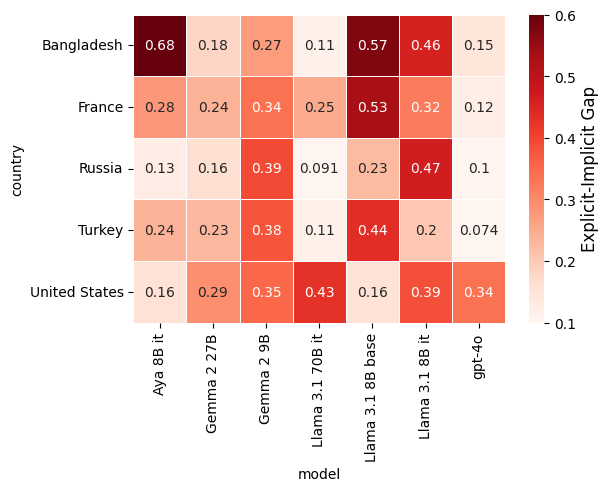

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))
heatmap = sns.heatmap(data2, 
                      annot=True, 
                      cmap='Reds', 
                      ax=ax, 
                      vmin=0.1, 
                      vmax=0.6,
                      linewidths=.7,     # Add white lines between cells
                      linecolor='white'   # Make the lines white
                      )# plt.colorbar(ax.collections[0], label='Explicit-Implicit Gap')# plt.colorbar(ax.collections[0], label='Explicit-Implicit Gap')
heatmap.collections[0].colorbar.set_label('Explicit-Implicit Gap', fontsize=12)

plt.savefig('visuals/explicit_implicit_gap.pdf', dpi=300, bbox_inches='tight')
plt.show()

suffix analysis

In [20]:
df_suffix = pd.read_csv('data/suffix_all_models_except_gpt4o.csv')
df_suffix2 = pd.read_csv('data/suffix_gpt4o.csv')
df_suffix2['model'] = 'gpt4o'
df_suffix = pd.concat([df_suffix, df_suffix2])

/tmp/ipykernel_1226360/1529717341.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_suffix = pd.read_csv('data/suffix_all_models_except_gpt4o.csv')


In [21]:
df_suffix = df_suffix[df_suffix['model'] != 'gemma2_9b_base']
df_suffix["translated"] = df_suffix.apply(lambda x: True if x["country"] == "United States" else x["lang"]!="English", axis=1)
string_form = lambda x: ("w/" if x["hint"] else "w/o") + " Hint | " + ("w/" if x["translated"] else "w/o") + " Tr."
df_suffix["hint_translated"] = df_suffix.apply(string_form, axis=1)

df_suffix = format_df(df_suffix)
# for some weird reason duplicates
df_suffix = df_suffix.drop_duplicates(subset=key_cols, keep='first')
df_suffix['correct'] = df_suffix['ans_type'].apply(lambda x: 1 if x == 'local' else 0)



In [22]:
df_suffix = df_suffix[df_suffix['ans_type'] != 'none']
df_suffix['swap_count'] = df_suffix.groupby(key_cols2)['ans_type'].transform('count')
df_suffix = df_suffix[df_suffix['swap_count'] > 1]


In [23]:
data = df_suffix.groupby(['hint_translated','model','country'])['correct'].mean().reset_index()
data['hint_translated'] = 'suffix'
# df31 = data[data['hint_translated'] == 'w/o Hint | w/ Tr.']
# df32 = data[data['hint_translated'] == 'w/ Hint | w/o Tr.']
# df321 = data[(data['hint_translated'] == 'w/ Hint | w/ Tr.') & (data['country'] == 'United States')]
# df32 = pd.concat([df32, df321])
# df31.reset_index(drop=True, inplace=True)
# df32.reset_index(drop=True, inplace=True)
# data =df31.merge(df32, on=['model', 'country'], suffixes=('_no_hint', '_with_hint'))
# data['diff'] = data['correct_with_hint'] - data['correct_no_hint']

In [24]:
data['model'] = data['model'].apply(lambda x: model_fig_names[x])

In [25]:
data = data.merge(data5, on=['model','country'], suffixes=('_suffix', '_explicit'))

In [26]:
data

,hint_translated,model,country,correct,hint_translated_no_hint,correct_no_hint,hint_translated_with_hint,correct_with_hint
0,suffix,Aya 8B it,Bangladesh,0.675000,w/o Hint | w/ Tr.,0.277778,w/ Hint | w/o Tr.,0.956204
1,suffix,Aya 8B it,France,0.826642,w/o Hint | w/ Tr.,0.635468,w/ Hint | w/o Tr.,0.913696
2,suffix,Aya 8B it,Russia,0.859583,w/o Hint | w/ Tr.,0.812195,w/ Hint | w/o Tr.,0.938343
3,suffix,Aya 8B it,Turkey,0.856105,w/o Hint | w/ Tr.,0.706806,w/ Hint | w/o Tr.,0.945205
4,suffix,Aya 8B it,United States,0.689781,w/o Hint | w/ Tr.,0.725240,w/ Hint | w/ Tr.,0.882569
5,suffix,Gemma 2 27B,Bangladesh,0.856649,w/o Hint | w/ Tr.,0.798982,w/ Hint | w/o Tr.,0.980287
6,suffix,Gemma 2 27B,France,0.848432,w/o Hint | w/ Tr.,0.707500,w/ Hint | w/o Tr.,0.948052
7,suffix,Gemma 2 27B,Russia,0.877917,w/o Hint | w/ Tr.,0.790576,w/ Hint | w/o Tr.,0.954198
8,suffix,Gemma 2 27B,Turkey,0.898485,w/o Hint | w/ Tr.,0.754753,w/ Hint | w/o Tr.,0.984940
9,suffix,Gemma 2 27B,United States,0.763242,w/o Hint | w/ Tr.,0.630137,w/ Hint | w/ Tr.,0.923077


In [27]:
data['diff'] = data['correct_with_hint'] - data['correct']

In [28]:
data3 = data.pivot(index='country', columns='model', values='diff')

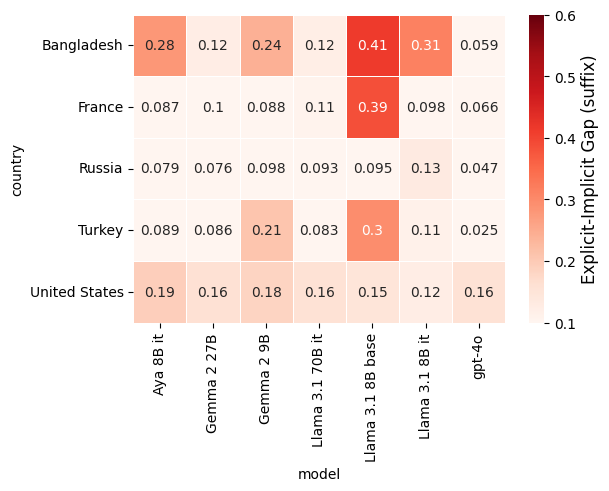

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))
# plt.subplots_adjust(hspace=0.4)  # Increase vertical space between subplots
heatmap = sns.heatmap(data3, 
                      annot=True, 
                      cmap='Reds', 
                      ax=ax, 
                      vmin=0.1, 
                      vmax=0.6,
                      linewidths=.7,     # Add white lines between cells
                      linecolor='white'   # Make the lines white
                      )# plt.colorbar(ax.collections[0], label='Explicit-Implicit Gap')
heatmap.collections[0].colorbar.set_label('Explicit-Implicit Gap (suffix)', fontsize=12)

plt.savefig('visuals/explicit_implicit_gap_suffix.pdf', dpi=300, bbox_inches='tight')
plt.show()